# Train a Model via API

This notebook demonstrates how to train, test and infer the FastFlow model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [1]:
%pip install anomalib

Note: you may need to restart the kernel to use updated packages.


## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [2]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent / "datasets" / "MVTec"

## Imports


In [3]:
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader

from anomalib.data import PredictDataset, MVTec
from anomalib.engine import Engine
from anomalib.models import Fastflow
from anomalib.utils.post_processing import superimpose_anomaly_map
from anomalib import TaskType

/home/djameln/miniconda3/envs/torch_version_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:


In [4]:
task = TaskType.SEGMENTATION

In [5]:
datamodule = MVTec(
    root=dataset_root,
    category="bottle",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=task,
)

## FastFlow Model

Now that we have created the MVTec datamodule, we could create the FastFlow model. We could start with printing its docstring.


In [6]:
Fastflow??

Init signature:
Fastflow(
    backbone: str = 'resnet18',
    pre_trained: bool = True,
    flow_steps: int = 8,
    conv3x3_only: bool = False,
    hidden_ratio: float = 1.0,
) -> None
Source:        
class Fastflow(AnomalyModule):
    """PL Lightning Module for the FastFlow algorithm.

    Args:
        input_size (tuple[int, int]): Model input size.
            Defaults to ``(256, 256)``.
        backbone (str): Backbone CNN network
            Defaults to ``resnet18``.
        pre_trained (bool, optional): Boolean to check whether to use a pre_trained backbone.
            Defaults to ``True``.
        flow_steps (int, optional): Flow steps.
            Defaults to ``8``.
        conv3x3_only (bool, optinoal): Use only conv3x3 in fast_flow model.
            Defaults to ``False``.
        hidden_ratio (float, optional): Ratio to calculate hidden var channels.
            Defaults to ``1.0`.
    """

    def __init__(
        self,
        backbone: str = "resnet18",
        pre_tra

In [7]:
model = Fastflow(backbone="resnet18", flow_steps=8)

## Callbacks

To train the model properly, we will to add some other "non-essential" logic such as saving the weights, early-stopping, normalizing the anomaly scores and visualizing the input/output images. To achieve these we use `Callbacks`. Anomalib has its own callbacks and also supports PyTorch Lightning's native callbacks. So, let's create the list of callbacks we want to execute during the training.


In [8]:
callbacks = [
    ModelCheckpoint(
        mode="max",
        monitor="pixel_AUROC",
    ),
    EarlyStopping(
        monitor="pixel_AUROC",
        mode="max",
        patience=3,
    ),
]

## Training

Now that we set up the datamodule, model, optimizer and the callbacks, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict pipeline. Let's create the engine object to train the model.


In [9]:
engine = Engine(
    model=model,
    callbacks=callbacks,
    pixel_metrics="AUROC",
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    logger=False,
)

`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/engine.html) to see how it could be tweaked to your needs.

Let's train the model now.


In [10]:
engine.fit(datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/djameln/miniconda3/envs/torch_version_test/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
No implementation of `configure_transforms` was provided in the Lightning model. Using default transforms from the base class. This may not be suitable for your use case. Please override `configure_transforms` in your model.
/home/djameln/miniconda3/envs/torch_version_test/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utiliz

Epoch 0:   0%|          | 0/7 [00:00<?, ?it/s] 

/home/djameln/miniconda3/envs/torch_version_test/lib/python3.10/site-packages/lightning/pytorch/core/module.py:491: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 11: 100%|██████████| 7/7 [00:08<00:00,  0.82it/s, train_loss_step=-4.98e+5, pixel_AUROC=0.976, train_loss_epoch=-4.77e+5]


The training has finished after 12 epochs. This is because, we set the `EarlyStopping` criteria with a patience of 3, which terminated the training after `pixel_AUROC` stopped improving. If we increased the `patience`, the training would continue further.

## Testing

Now that we trained the model, we could test the model to check the overall performance on the test set. We will also be writing the output of the test images to a file since we set `VisualizerCallback` in `callbacks`.


In [11]:
engine.test(datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/djameln/miniconda3/envs/torch_version_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
│        pixel_AUROC        │    0.9755250215530396     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUROC': 0.9755250215530396, 'image_AUROC': 1.0, 'image_F1Score': 1.0}]

## Inference

Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an `PredictDataset` to let you create an inference dataset. So let's try it.


In [12]:
inference_dataset = PredictDataset(path=dataset_root / "bottle/test/broken_large/000.png")
inference_dataloader = DataLoader(dataset=inference_dataset)

We could utilize `Trainer`'s `predict` method to infer, and get the outputs to visualize


In [13]:
predictions = engine.predict(dataloaders=inference_dataloader)[0]

ckpt_path is not provided. Model weights will not be loaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/djameln/miniconda3/envs/torch_version_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


`predictions` contain image, anomaly maps, predicted scores, labels and masks. These are all stored in a dictionary. We could check this by printing the `prediction` keys.


In [14]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}',
)

Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


## Visualization


To properly visualize the predictions, we will need to perform some post-processing operations.

Let's first show the input image. To do so, we will use `image_path` key from the `predictions` dictionary, and read the image from path. Note that `predictions` dictionary already contains `image`. However, this is the normalized image with pixel values between 0 and 1. We will use the original image to visualize the input image.

In [15]:
image_path = predictions["image_path"][0]
image_size = predictions["image"].shape[-2:]
image = np.array(Image.open(image_path).resize(image_size))

The first output of the predictions is the anomaly map. As can be seen above, it's also a torch tensor and of size `torch.Size([1, 1, 256, 256])`. We therefore need to convert it to numpy and squeeze the dimensions to make it `256x256` output to visualize.


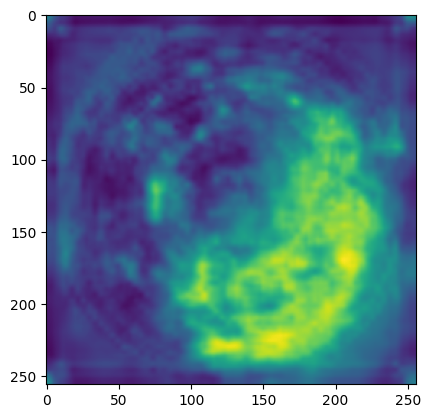

In [16]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

We could superimpose (overlay) the anomaly map on top of the original image to get a heat map. Anomalib has a built-in function to achieve this. Let's try it.


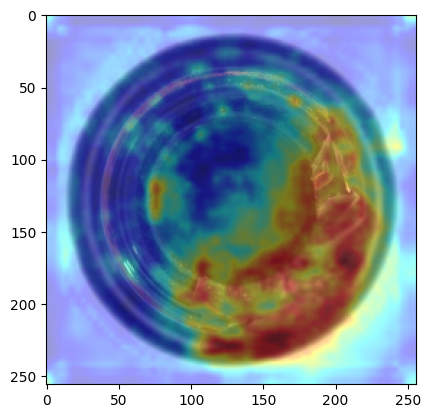

In [17]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

`predictions` also contains prediction scores and labels.


In [18]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.6206) tensor(True)


The last part of the predictions is the mask that is predicted by the model. This is a boolean mask containing True/False for the abnormal/normal pixels, respectively.


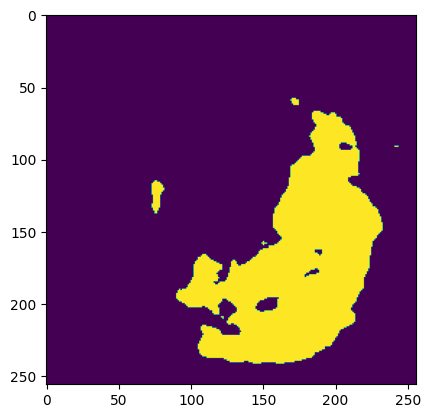

In [19]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

That wraps it! In this notebook, we show how we could train, test and finally infer a FastFlow model using Anomalib API.
